# Cepstral strain mapping of PTO / DSO

Colin Ophus - 2021 July 12

This notebook measures the strain fields of an experimental 4D-STEM dataset recorded PTO on an DSO substrate. This tutorial was written for py4DSTEM version 0.12.3

[Download the experimental PTO dataset](https://drive.google.com/file/d/1zkCDTy5RWbJhrbLlCVvnJjsloDLmIPod/view?usp=sharing).

### Strain measurement

The method used to measure strain is correlation of a probe template, for more information see the
[py4DSTEM paper](https://doi.org/10.1017/S1431927621000477).

### Data source

This experimental dataset was provided by David Muller at Cornell [TODO-add other credits]
[TODO - add citation]

# Data file paths, imports

In [1]:
import py4DSTEM
import numpy as np
# import matplotlib.pyplot as plt

In [2]:
py4DSTEM.__version__

'0.12.3'

In [25]:
# File paths - output files will be augmented with the correct file extension
file_path_input = '/media/cophus/DATA/4DSTEM/PTODSO_small_128x130x64x64_float_x64_y64.raw'
file_path_output = '/media/cophus/DATA/4DSTEM/PTODSO_strain_correlation_log'
# file_path_input = 'C:/data/SiGe_sims/Ge_SiGe_multilayer_stack_ideal.h5'
# file_path_output = 'C:/data/SiGe_sims/output_Ge_SiGe_multilayer_stack_ideal'

In [4]:
# manual reading of EMPAD data
data_size = (64, 64, 130, 128)
dataset = py4DSTEM.io.DataCube(data=np.reshape(np.fromfile(file_path_input, dtype='16384float32'),data_size))

# Simple visualizations

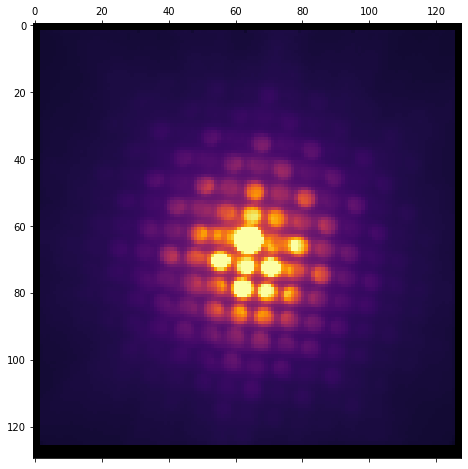

In [5]:
# Plot the mean CBED
diffraction_pattern_mean = np.mean(dataset.data, axis=(0,1))
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    clipvals='manual',
    min=0,
    max=4e4,
    scaling='power',
    power=0.5,
    cmap='inferno')

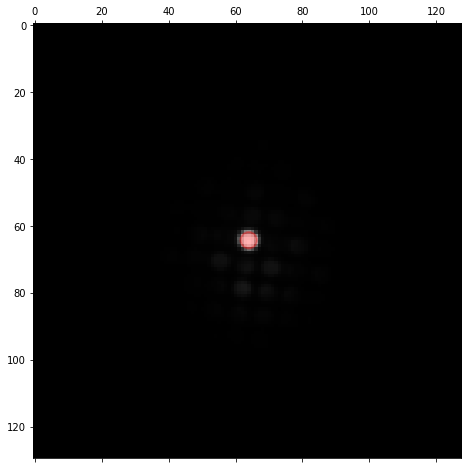

Estimated probe radius = 2.47 pixels


In [6]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(
    diffraction_pattern_mean)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    diffraction_pattern_mean, 
    (qx0, qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

In [7]:
# Next, create a BF virtual detector using the the center beam position (qxy0, qy0), and a virtual DF detector.
# The DF virtual detector will be set to high scattering angles, picking up just a hint of the coherent diffraction.
expand_BF = 2.0
det_DF = (75,1000)

image_BF = py4DSTEM.process.virtualimage.get_virtualimage_circ(
    dataset, 
    qx0, qy0, 
    probe_semiangle + expand_BF)
image_DF = py4DSTEM.process.virtualimage.get_virtualimage_ann(
    dataset, 
    qx0, qy0, 
    det_DF[0],
    det_DF[1])

100%|████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:00<00:00, 44571.63it/s]


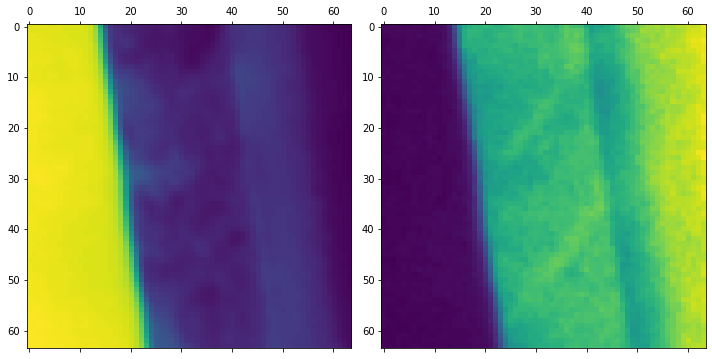

In [8]:
# Show the BF and DF images
py4DSTEM.visualize.show_image_grid(
    lambda i:[image_BF, image_DF][i],H=1,W=2,
    axsize=(5,5),
    cmap='viridis')

# Bragg disk detection

Because the disks are so close together and no vacuum probe measurement is available, we will generate a synthetic probe kernel.

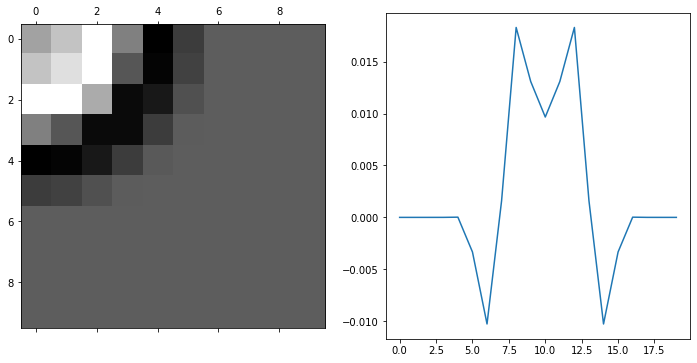

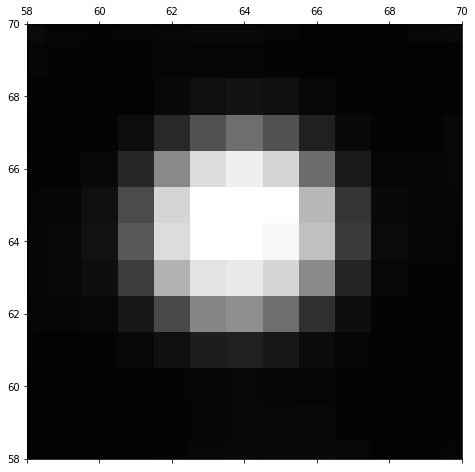

In [9]:
# Dimensions of the synthetic probe
probe_radius = 3
probe_width = 1.5

# Make the synthetic probe function
probe_synthetic = py4DSTEM.process.diskdetection.get_probe_synthetic(
    probe_radius, 
    probe_width, 
    dataset.Q_Nx, 
    dataset.Q_Ny)

# Subtract the normalization template, using a sine_squared kernel to localize the template
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(
    probe_synthetic, 
    probe_radius * 0.0,
    probe_radius * 2.0,
    type='sine_squared')

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(probe_kernel, R=10, L=10, W=2)

# plot mean experimental dark field image for comparison
fig, ax = py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    clipvals='manual',
    min=0,
    max=1e6,
    figsize=(8,8),
    returnfig=True)
ax.set_xlim((58, 70));
ax.set_ylim((58, 70));


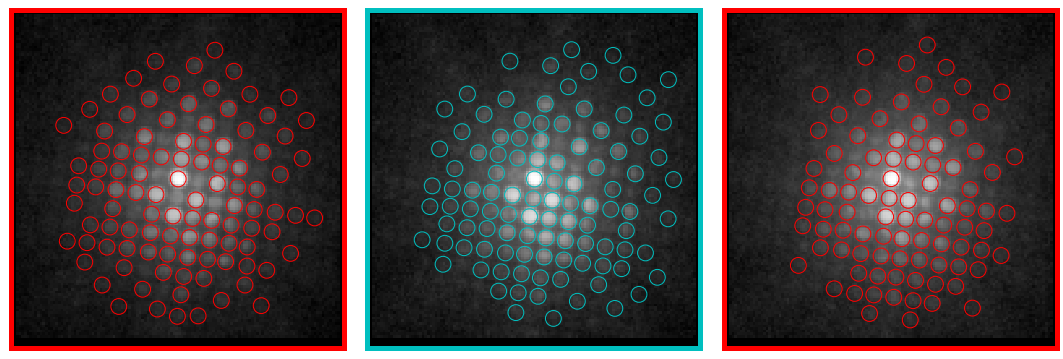

In [16]:
# Test hyperparameters on a few probe positions
rxs = 30,30,30
rys = 30,35,40
colors=['r','c','r','c','r','c']

dp0 = dataset.data[rxs[0],rys[0],:,:]
dp1 = dataset.data[rxs[1],rys[1],:,:]
dp2 = dataset.data[rxs[2],rys[2],:,:]

# Run the disk detection on the selected DPs
corrPower=1
sigma=0
edgeBoundary=8
minRelativeIntensity=0.1
relativeToPeak=0
minPeakSpacing=7
maxNumPeaks=200
subpixel='poly'
upsample_factor=10

disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    dataset,
    probe_kernel,
    rxs,
    rys,
    corrPower=corrPower,
    sigma=sigma,edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor,
    filter_function=lambda x: np.log(x+1))

py4DSTEM.visualize.show_image_grid(
    lambda i:[dp0,dp1,dp2][i],H=1,W=3,
    axsize=(5,5),
    scaling='power',
    power=0.1,                  
    get_bordercolor=lambda i:colors[i],                    
    get_x=lambda i:disks_selected[i].data['qx'],
    get_y=lambda i:disks_selected[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    open_circles=True,scale=250)

# Fit all Bragg peaks

In [17]:
# Find all Bragg peaks
# WARNING - this is the "slow" step, though it will only take ~8 minutes for a dataset of this size.
# Note the speed depends strongly on whether 'multicorr' (more accurate) or 'poly' (faster) is used.
bragg_peaks = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube=dataset,
    probe=probe_kernel,                 
    corrPower=corrPower,                       
    sigma=sigma,                 
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,    
    upsample_factor=upsample_factor,
    filter_function=lambda x: np.log(x+1)
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████████| 4.10k/4.10k [00:24<00:00, 168DP/s]


# Fit crystal lattice

In [26]:
# Center the Bragg disk positions about the origin.
bragg_peaks_centered = py4DSTEM.process.calibration.center_braggpeaks(
    bragg_peaks,
    qx0=qx0,
    qy0=qy0)

Computing Bragg vector map: 100%|███████████████████████████████████████████████████| 4.10k/4.10k [00:10<00:00, 388DP/s]


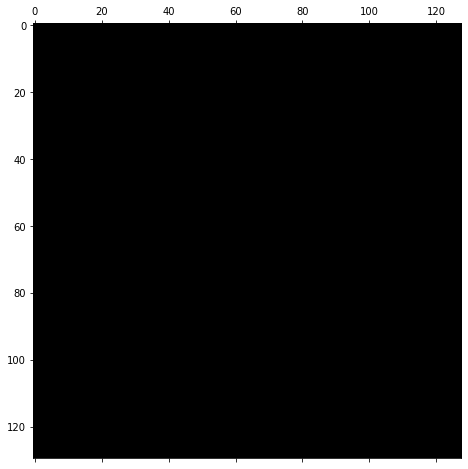

In [27]:
# Compute and plot Bragg vector map (BVM).
# This is a 2D histogram of all detected Bragg peaks.

# Compute the BVM
bragg_vector_map = py4DSTEM.process.diskdetection.get_bvm(
    bragg_peaks_centered,
    dataset.Q_Nx,
    dataset.Q_Ny)

# plot the BVM
py4DSTEM.visualize.show(
    bragg_vector_map,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e2)

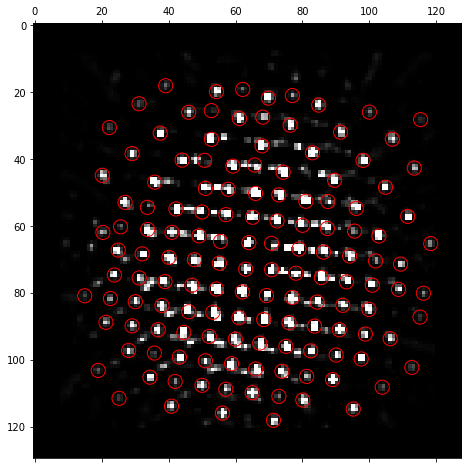

In [31]:
# Get all local maximum from the BVM, plot the candidate peaks
gx, gy, gI = py4DSTEM.process.utils.get_maxima_2D(
    bragg_vector_map,
    sigma=0, 
    edgeBoundary=4,
    minSpacing=6,
    minRelativeIntensity=0.001,
    relativeToPeak=0,
    maxNumPeaks=200,
    subpixel='multicorr'
)

# Plot the candidate lattice coordinates
py4DSTEM.visualize.show_points(
    bragg_vector_map,
    x=gx,
    y=gy,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e1,
    open_circles=True,
    scale=200)

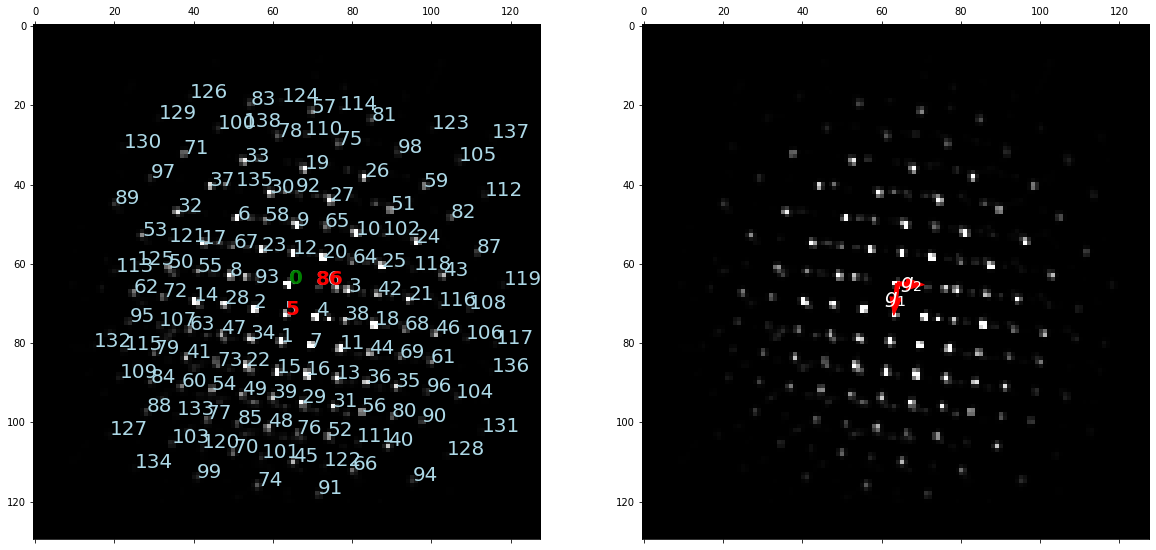

In [33]:
# Define peaks to use for computing strain maps
index_0, index_g1, index_g2 = 0, 5, 86

# Plot the selected lattice vectors - note they are in order of detected intensity
g1,g2 = py4DSTEM.visualize.select_lattice_vectors(
    bragg_vector_map,    
    figsize=(20,10),
    clipvals='manual',
    min=0,
    max=1e2,
    gx=gx,gy=gy,
    i0=index_0,
    i1=index_g1,
    i2=index_g2)

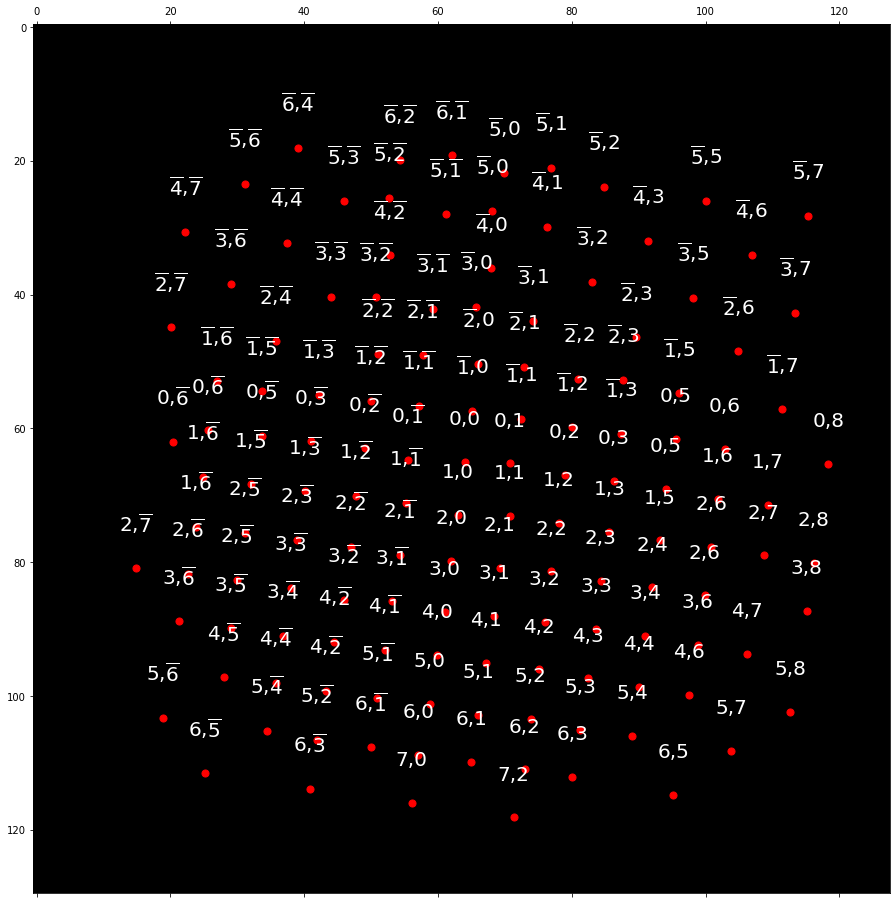

In [34]:
# Get indexing for all peaks, plot the indices overlaid onto the peaks
h, k, braggdirections = py4DSTEM.process.latticevectors.index_bragg_directions(
    qx0,qy0,
    gx,gy,
    g1,g2)
py4DSTEM.visualize.show_bragg_indexing(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=4e6,
    figsize=(16,16),
    braggdirections=braggdirections,
    points=True)

In [35]:
# maximum peak spacing from expected positions
max_peak_spacing = 3

# Add indices to the bragg_peaks PointListArray
bragg_peaks_indexed = py4DSTEM.process.latticevectors.add_indices_to_braggpeaks(
    bragg_peaks_centered,
    braggdirections,
    maxPeakSpacing=max_peak_spacing,
    qx_shift=qx0,
    qy_shift=qy0)

In [36]:
# Fit the lattice in all diffraction images
g1g2_map = py4DSTEM.process.latticevectors.fit_lattice_vectors_all_DPs(bragg_peaks_indexed)

100%|█████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:00<00:00, 7604.51it/s]


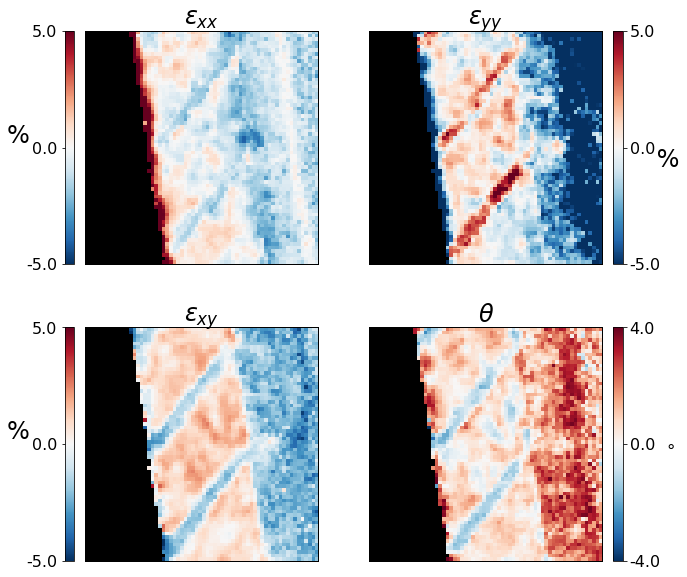

In [37]:
# Compute thae strain using the median of the measured g1g2 as reference
strainmap_mediang1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_region(
    g1g2_map,
    mask=np.ones((dataset.R_Nx,dataset.R_Ny),dtype=bool))

# Rotate the lattice direction of the strain map 
# (pattern is rotated with respect to the scan direction)
g_reference = g1
strainmap = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_mediang1g2,
    g_reference[0],
    g_reference[1])

# plot the 4 components of the strain tensor
py4DSTEM.visualize.show_strain(
    strainmap,
    vrange_exx=[-5.0, 5.0],
    vrange_theta=[-4.0, 4.0],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(10,10))

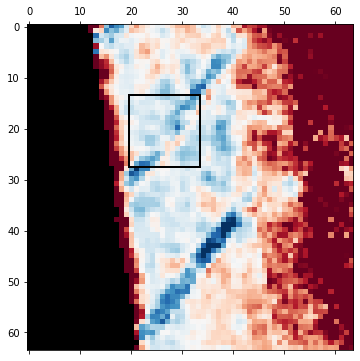

In [38]:
# Set the reference lattice to be the probe positions inside the substrate.
# x0,xf = 0,40
# y0,yf = 45,52
# x0,xf = 20,36
# y0,yf = 30,40
x0,xf = 14,28
y0,yf = 20,34

py4DSTEM.visualize.show(
    strainmap.slices['e_yy'],              
    mask=strainmap.slices['mask'],
    figsize=(6, 6),
    clipvals='manual',
    min=-0.05,
    max=0.05,
    cmap='RdBu',
    rectangle={'lims':(x0,xf,y0,yf),'fill':False,'color':'k'})

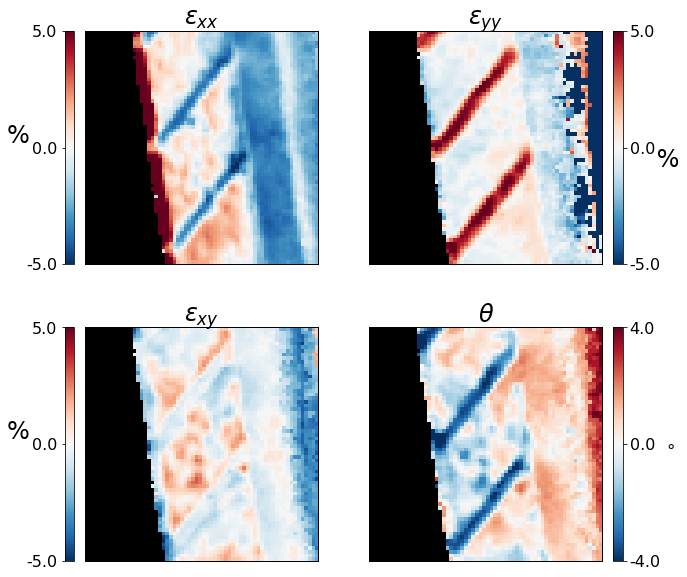

In [302]:
# Get new reference lattice vectors
mask = np.zeros((dataset.R_Nx,dataset.R_Ny),dtype=bool)
mask[x0:xf,y0:yf] = True
g1_ref,g2_ref = py4DSTEM.process.latticevectors.get_reference_g1g2(g1g2_map, mask)

# Recalculate the strain maps using the new reference lattice
strainmap_ROI_g1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_g1g2(
    g1g2_map,
    g1_ref,
    g2_ref)

# Rotate the lattice direction of the strain map 
strainmap_ROI = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_ROI_g1g2,
    g_reference[0],
    g_reference[1])

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap_ROI,
    vrange_exx=[-5.0, 5.0],
    vrange_theta=[-4.0, 4.0],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(10,10),
    returnfig=True)

# Save data and strain maps

In [304]:
# Strain map figure
fig.savefig(file_path_output + '.pdf')

In [305]:
# Save all data in py4DSTEM format
# The diffraction space arrays we will save are:
file_path_output_h5 =  file_path_output + '.h5'
diff = py4DSTEM.io.DiffractionSlice(
    data=np.dstack([diffraction_pattern_mean, 
                    probe_kernel]),    
    slicelabels=['image_mean',
                 'probe_kernel'],
    name='diffraction_images')

# The real space arrays we will save are:
real = py4DSTEM.io.RealSlice(
    data=np.dstack([image_BF, 
                    image_DF]),    
    slicelabels=['bright_field',
                 'dark_field'],
    name='real_space_images')

# Note we will also save the strain maps, but these are already stored as RealSlice objects.
# We will also store the center coordinates, estimated radius in pixels, strain reference direction,
# but most importantly - the Bragg disk positions and intensities (bragg_peaks_centered).
probe_fields = [("probe_semiangle",float),
              ("qx0", float),
              ("qy0", float)]
probe_data = py4DSTEM.io.PointList(coordinates=probe_fields)
probe_data.add_point((probe_semiangle, qx0, qy0))
probe_data.name = 'probe_data'

# Save all of the resulting data into a single .h5 file:
py4DSTEM.io.save(file_path_output_h5,
                 [diff,
                  real,
                  probe_data,
                  strainmap_ROI,                  
                  bragg_peaks_centered],
                 overwrite=True)

 12%|█████████▌                                                                    | 504/4096 [00:00<00:00, 5039.28it/s]

Saving DiffractionSlice 'diffraction_images'...
Saving RealSlice 'real_space_images'...
Saving PointList 'probe_data'...
Saving RealSlice 'strain_map_rotated'...
Saving PointListArray 'braggpeaks_centered'...


100%|█████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:00<00:00, 5190.15it/s]


In [306]:
# Check the results of the h5 file we just created
py4DSTEM.io.read(file_path_output_h5)

py4DSTEM file version 0.12.3
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DiffractionSlice  (130, 128, 2)           diffraction_images                                    
  1       RealSlice         (64, 64, 2)             real_space_images                                     
  2       RealSlice         (64, 64, 5)             strain_map_rotated                                    
  3       PointList         (3, 1)                  probe_data                                            
  4       PointListArray    (64, 64, 3, -1)         braggpeaks_centered                                   
